In [151]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.io import wavfile
from scipy.signal import stft

# EDA and Visualization

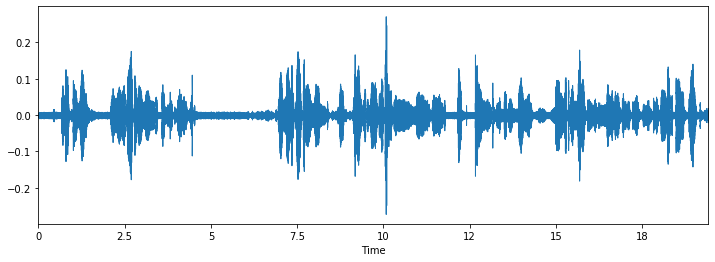

In [152]:
train_audio_path = "dataset/LibriSpeech/train-clean-100/103/1240/"
samples, sample_rate = librosa.load(train_audio_path + "103-1240-0000.flac")
plt.figure(figsize=(12, 4))
librosa.display.waveplot(samples, sr=16000)

In [153]:
ipd.Audio(samples, rate=sample_rate)

In [154]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

In [155]:
import glob
path = train_audio_path + "*.flac"
# records data
voice = glob.glob(path)

In [156]:
def load_wav(x):
    samples, sample_rate = librosa.load(x, res_type='kaiser_fast')
    mfcc = np.mean(librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=40).T, axis=0)
    # Normalize
        
    return mfcc

In [157]:
def read_wav_file(x):
    # Read wavfile using scipy wavfile.read
    wav, _ = librosa.load(x) 
    # Normalize
    wav = wav.astype(np.float32) / np.iinfo(np.int16).max
        
    return wav

# spectrogram

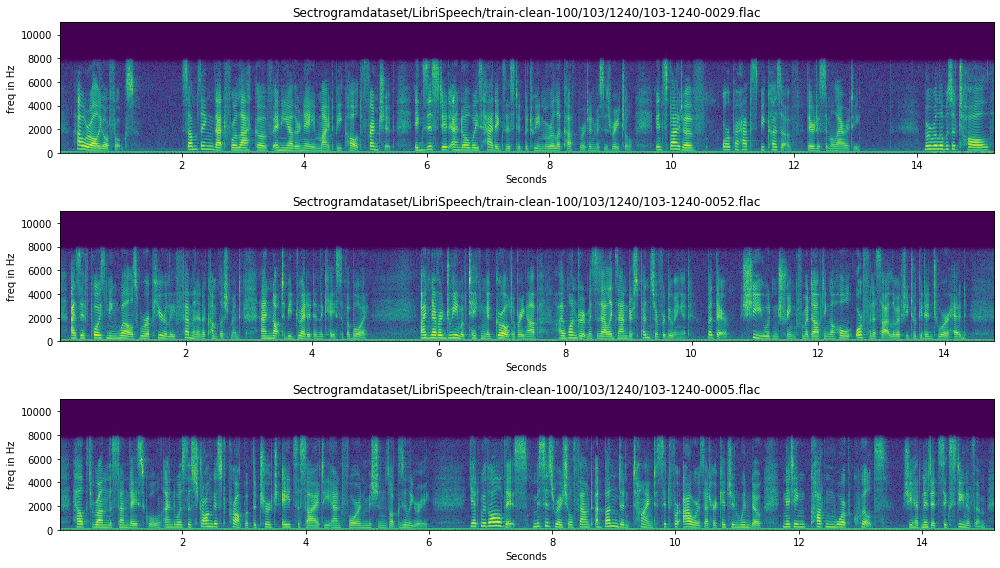

In [158]:
def spectrogram(wav):
    freqs, times, spec = stft(wav, sample_rate, 
                              nperseg = 400, 
                              noverlap = 240, 
                              nfft = 512, 
                              padded = False, 
                              boundary = None)
    # log spectrogram
    amp = np.log(np.abs(spec)+1e-10)
    
    return freqs, times, amp

fig = plt.figure(figsize=(14, 8))
for i, fn in enumerate(voice[:3]):
    wav = read_wav_file(fn)
    freqs, times, amp = spectrogram(wav)
    
    ax = fig.add_subplot(3, 1, i+1)
    ax.imshow(amp, aspect="auto", origin="lower",
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    
    ax.set_title("Sectrogram" + fn)
    ax.set_ylabel("freq in Hz")
    ax.set_xlabel("Seconds")

fig.tight_layout()

In [159]:
voice_data = []
for i in voice:
    voice_data.append(load_wav(i))

In [160]:
x = np.array(voice_data)

**duration of recoding**

(array([ 1.,  0.,  2.,  1.,  2.,  2.,  4.,  9., 27., 10.]),
 array([ 3.81002268,  5.11502041,  6.42001814,  7.72501587,  9.03001361,
        10.33501134, 11.64000907, 12.9450068 , 14.25000454, 15.55500227,
        16.86      ]),
 <a list of 10 Patch objects>)

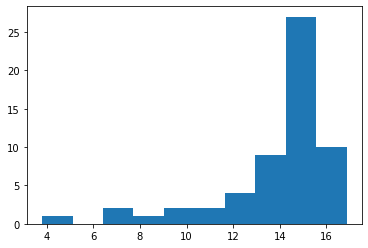

In [161]:
duration_of_recordings = []
for wav in voice:
        samples, sample_rate,  = librosa.load(wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [162]:
def load_lables(path):
    # open a txt file as read only
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    return lines

# Preprocessing

In [163]:
# load text lables
lines = load_lables("dataset/LibriSpeech/train-clean-100/103/1240/103-1240.trans.txt")
# remove chapter num
labels = [re.sub(r"[^a-zA-Z]+", " ", i).strip() for i in lines]
train_audio_path = "dataset/LibriSpeech/train-clean-100/103/1240/"

# all_wave = []
# for i in voice:
#     samples, sample_rate = librosa.load(i)
#     samples = librosa.resample(samples, sample_rate, 8000)
#     all_wave.append(samples)


In [167]:
len(labels),len(voice_data)

(58, 58)

In [171]:
# convert output labels to integer encode
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(labels)
classes = list(le.classes_)

In [172]:
from keras.utils import np_utils
# onehot encode → it is a multi classification problem
y = np_utils.to_categorical(y)

In [73]:
# reshape 2d array to 3d, input to the conv1d nust be a 3d array
all_wave = np.array(voice_data).reshape(-1, 58, 1)

In [175]:
len(voice_data), len(labels)

(58, 58)

**split train and val set**

In [86]:
import pandas as pd
df = pd.DataFrame({"wavs file": voice, "labels": labels})
df.head()

,wavs file,labels
0,dataset/LibriSpeech/train-clean-100/103/1240/1...,CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED M...
1,dataset/LibriSpeech/train-clean-100/103/1240/1...,THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF ...
2,dataset/LibriSpeech/train-clean-100/103/1240/1...,FOR NOT EVEN A BROOK COULD RUN PAST MISSUS RAC...
3,dataset/LibriSpeech/train-clean-100/103/1240/1...,AND THAT IF SHE NOTICED ANYTHING ODD OR OUT OF...
4,dataset/LibriSpeech/train-clean-100/103/1240/1...,BUT MISSUS RACHEL LYNDE WAS ONE OF THOSE CAPAB...


In [139]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D,  MaxPool2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics

num_labels = y.shape[1]
filter_size = 2

# build model
model = Sequential()

model.add(Dense(256, input_shape=(40, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
 
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="Adam")

In [176]:
from sklearn.model_selection import train_test_split
# test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# val set
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = x_train.reshape(x_train.shape[0], 40)
model.fit(x_train, y_train, batch_size=16, epochs=5, validation_data=(x_val, y_val))

W1203 20:28:15.464637 140735864492928 deprecation.py:323] From /Users/miyamotoatsushi/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1203 20:28:15.784013 140735864492928 module_wrapper.py:139] From /Users/miyamotoatsushi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1203 20:28:15.954210 140735864492928 module_wrapper.py:139] From /Users/miyamotoatsushi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W1203 20:28:16.169748 140735864492928 module_wrapper.py:139] From /Users/miyamotoatsushi/anaconda3/lib/python3.7/site-packages/keras/backend/t

Train on 46 samples, validate on 12 samples
Epoch 1/5


W1203 20:28:16.795309 140735864492928 module_wrapper.py:139] From /Users/miyamotoatsushi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



46/46 [==============================] - 1s 26ms/step - loss: 15.0539 - acc: 0.0435 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/5
46/46 [==============================] - 0s 405us/step - loss: 15.7687 - acc: 0.0217 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 3/5
46/46 [==============================] - 0s 287us/step - loss: 15.9096 - acc: 0.0000e+00 - val_loss: 16.0358 - val_acc: 0.0000e+00
Epoch 4/5
46/46 [==============================] - 0s 510us/step - loss: 16.0183 - acc: 0.0000e+00 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 5/5
46/46 [==============================] - 0s 263us/step - loss: 15.5489 - acc: 0.0217 - val_loss: 16.1181 - val_acc: 0.0000e+00


In [149]:
np.array(y_train).shape

(46, 58, 58, 2)